In [2]:
import pandas as pd
import numpy as np
data = pd.read_parquet('data.parquet')
data['date'] = pd.to_datetime(data['clock']).dt.date
data.head()

,clock,clock_int,symbol,current,open,high,low,volume,money,tot_volume,...,bid_price8,ask_volume9,ask_price9,bid_volume9,bid_price9,ask_volume10,ask_price10,bid_volume10,bid_price10,date
0,2023-07-03 09:30:01.000,93001000,S.CN.SSE.603000,30.000000,30.16,30.16,29.879999,112700.0,3384224.0,1639300,...,29.730000,1600.0,30.110001,1200.0,29.700001,39336.0,30.120001,500.0,29.680000,2023-07-03
1,2023-07-03 09:30:04.000,93004000,S.CN.SSE.603000,29.990000,30.16,30.16,29.780001,236200.0,7083776.0,1875500,...,29.709999,68000.0,30.100000,1200.0,29.700001,23900.0,30.110001,700.0,29.680000,2023-07-03
2,2023-07-03 09:30:07.000,93007000,S.CN.SSE.603000,29.799999,30.16,30.16,29.650000,366100.0,10964384.0,2241600,...,29.660000,32500.0,30.080000,4200.0,29.650000,13400.0,30.090000,300.0,29.610001,2023-07-03
3,2023-07-03 09:30:11.000,93011000,S.CN.SSE.603000,29.799999,30.16,30.16,29.650000,342400.0,10237000.0,2584000,...,29.530001,34100.0,30.000000,10300.0,29.520000,2100.0,30.010000,1200.0,29.510000,2023-07-03
4,2023-07-03 09:30:14.000,93014000,S.CN.SSE.603000,30.049999,30.16,30.16,29.639999,339037.0,10131104.0,2923037,...,29.610001,96400.0,30.120001,59200.0,29.600000,435300.0,30.129999,7000.0,29.580000,2023-07-03


计算因子:

In [3]:
def calc_VOI(data):
    '''
    Volume Order Imbalance
    '''
    #计算衰减加权委托量
    vol_weights = np.array([1 - (i / 5) for i in range(4)])
    bid_volumes = data[[f'bid_volume{i+1}' for i in range(4)]].values
    VB = (bid_volumes * vol_weights).sum(axis=1) / vol_weights.sum()
    ask_volumes = data[[f'ask_volume{i+1}' for i in range(4)]].values
    VA = (ask_volumes * vol_weights).sum(axis=1) / vol_weights.sum()

    bid_price1 = data['bid_price1'].values
    ask_price1 = data['ask_price1'].values

    #获取满足条件的索引
    #bid_neg = np.where(np.diff(bid_price1) < 0)[0] + 1
    bid_equal = np.where(np.diff(bid_price1) == 0)[0] + 1
    bid_pos = np.where(np.diff(bid_price1) > 0)[0] + 1
    ask_neg = np.where(np.diff(ask_price1) < 0)[0] + 1
    ask_equal = np.where(np.diff(ask_price1) == 0)[0] + 1
    #ask_pos = np.where(np.diff(ask_price1) > 0)[0] + 1

    delta_VB = np.zeros_like(VB)
    delta_VA = np.zeros_like(VA)
    delta_VB[bid_equal] = VB[bid_equal] - VB[bid_equal - 1]
    delta_VB[bid_pos] = VB[bid_pos]
    delta_VA[ask_neg] = VA[ask_neg]
    delta_VA[ask_equal] = VA[ask_equal] - VA[ask_equal - 1]

    VOI = delta_VB - delta_VA
    data['VOI'] = VOI

    return data

def calc_OIR(data):
    '''
    订单失衡
    '''
    vol_weights = np.array([1 - (i / 5) for i in range(4)])
    bid_volumes = data[[f'bid_volume{i+1}' for i in range(4)]].values
    VB = (bid_volumes * vol_weights).sum(axis=1) / vol_weights.sum()
    ask_volumes = data[[f'ask_volume{i+1}' for i in range(4)]].values
    VA = (ask_volumes * vol_weights).sum(axis=1) / vol_weights.sum()

    OIR = (VB - VA) / (VB + VA)
    data['OIR'] = OIR

    return data

def calc_mid_price(data):
    mid_price = (data['ask_price1'] + data['bid_price1']) / 2
    data['mid_price'] = mid_price
    return data

def calc_spread(data):
    spread = data['ask_price1'] - data['bid_price1']
    data['spread'] = spread
    return data

def calc_single_OR(data, i):
    '''
    计算第i档的订单失衡因子
    '''
    D_bidprice = np.diff(data[f'bid_price{i}'], prepend=0)
    D_askprice = np.diff(data[f'ask_price{i}'], prepend=0)
    delta_VB = np.where(D_bidprice==0, data[f'bid_volume{i}'] - np.roll(data[f'bid_volume{i}'], 1), np.where(D_bidprice>0, data[f'bid_volume{i}'], (-1) * np.roll(data[f'bid_volume{i}'], 1)))
    delta_VA = np.where(D_askprice==0, data[f'ask_volume{i}'] - np.roll(data[f'ask_volume{i}'], 1), np.where(D_askprice<0, data[f'ask_volume{i}'], (-1) * np.roll(data[f'ask_volume{i}'], 1)))
    OR = delta_VB - delta_VA
    return OR

def calc_MOFI(data):
    '''
    多层次订单失衡
    '''
    weights = [(i+1) / 5 for i in range(5)]
    OFI = [calc_single_OR(data, i+1) for i in range(5)]
    MOFI = np.average(OFI, axis=0, weights=weights)
    data['MOFI'] = MOFI

    return data

def calc_PIR(data):
    '''
    买卖委托价格比率
    '''
    weights = [1 - i / 5 for i in range(5)]
    bid_price = data[[f'bid_price{i+1}' for i in range(5)]]
    ask_price = data[[f'ask_price{i+1}' for i in range(5)]]
    W_bidprice = np.average(bid_price, axis=1, weights=weights)
    W_askprice = np.average(ask_price, axis=1, weights=weights)
    PIR = (W_bidprice - W_askprice) / (W_bidprice + W_askprice)

    data['PIR'] = PIR
    return data

def calc_MLQS(data):
    '''
    多层订单斜率
    '''
    LogquoteSlope = pd.DataFrame()
    weights = [(i+1) / 5 for i in range(5)]
    bid_price = np.log(data[[f'bid_price{i+1}' for i in range(5)]])
    ask_price = np.log(data[[f'ask_price{i+1}' for i in range(5)]])
    bid_volume = np.log(data[[f'bid_volume{i+1}' for i in range(5)]])
    ask_volume = np.log(data[[f'ask_volume{i+1}' for i in range(5)]])
    for i in range(5):
        LogquoteSlope[f'logslope{i}'] = (bid_price[f'bid_price{i+1}'] - ask_price[f'ask_price{i+1}']) / (bid_volume[f'bid_volume{i+1}'] + ask_volume[f'ask_volume{i+1}'])
    MLQS = np.average(LogquoteSlope, axis=1, weights=weights)
    data['MLQS'] = MLQS
    return data


In [4]:
data_ = data.copy()
data_ = data_.groupby('date').apply(calc_VOI).reset_index(drop=True)
data_ = data_.groupby('date').apply(calc_OIR).reset_index(drop=True)
data_ = data_.groupby('date').apply(calc_mid_price).reset_index(drop=True)
data_ = data_.groupby('date').apply(calc_spread).reset_index(drop=True)
data_ = data_.groupby('date').apply(calc_MOFI).reset_index(drop=True)
data_ = data_.groupby('date').apply(calc_PIR).reset_index(drop=True)
data_ = data_.groupby('date').apply(calc_MLQS).reset_index(drop=True)

/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/4041389146.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_ = data_.groupby('date').apply(calc_VOI).reset_index(drop=True)
/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/4041389146.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_ = data_.groupby('date').apply(calc_OIR).reset_index(drop=True)
/var/folders/t7/

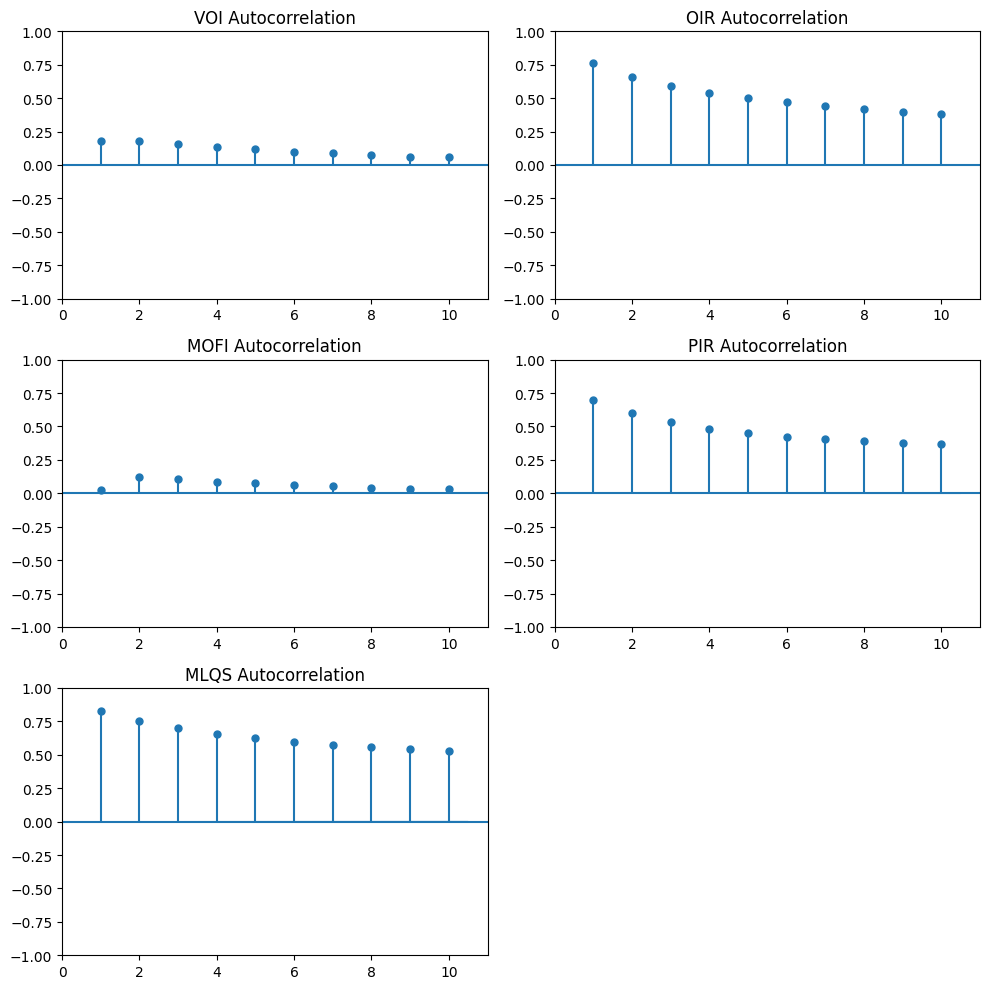

In [121]:
data_.dropna(inplace=True)
df = data_.copy()
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
plt.figure(1, figsize=(10,10))

ax1 = plt.subplot(321) 
plot_acf(df.VOI, ax=ax1, lags=np.arange(1, 11), title='VOI Autocorrelation')

ax2 = plt.subplot(322)
plot_acf(df.OIR, ax=ax2, lags=np.arange(1, 11), title='OIR Autocorrelation')

ax3 = plt.subplot(323) 
plot_acf(df.MOFI, ax=ax3, lags=np.arange(1, 11), title='MOFI Autocorrelation')

ax4 = plt.subplot(324) 
plot_acf(df.PIR, ax=ax4, lags=np.arange(1, 11), title='PIR Autocorrelation')

ax5 = plt.subplot(325)  
plot_acf(df.MLQS, ax=ax5, lags=np.arange(1, 11), title='MLQS Autocorrelation')

plt.tight_layout()
plt.savefig('my_figure.png')

plt.show()


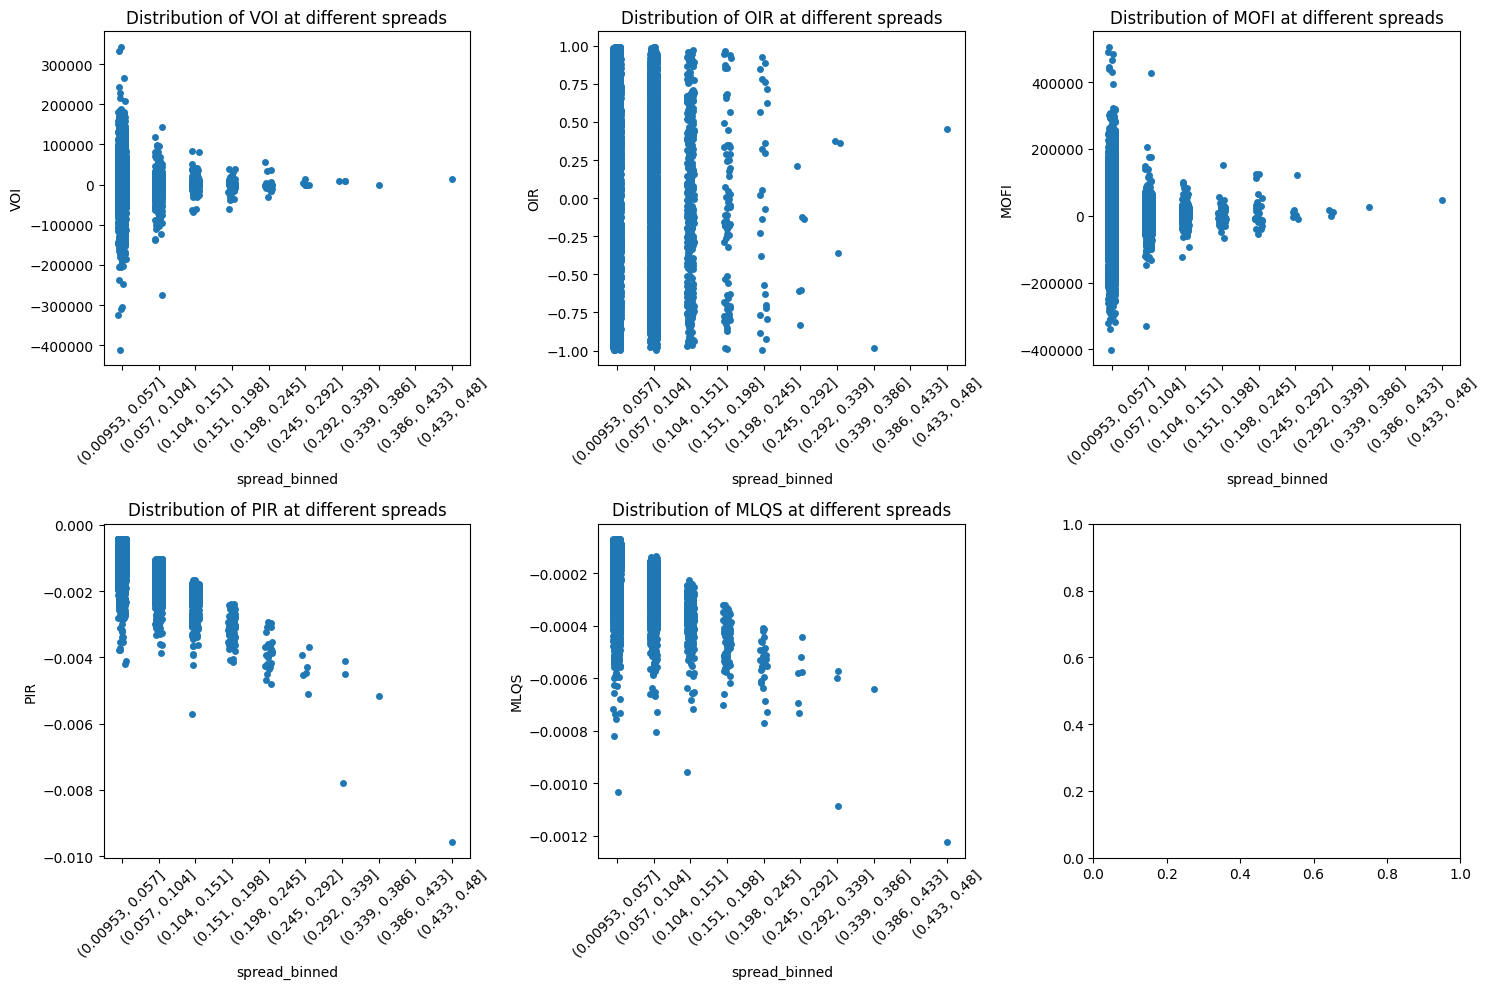

In [124]:
import matplotlib.pyplot as plt
import seaborn as sns

factors = ['VOI', 'OIR', 'MOFI', 'PIR', 'MLQS']
#data_.drop(columns='spread_binned', inplace=True)
data_['spread_binned'] = pd.cut(data_['spread'], bins=10)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, factor in enumerate(factors):
    sns.stripplot(x='spread_binned', y=factor, data=data_, ax=axs[i//3, i%3], jitter=True)
    axs[i//3, i%3].set_title(f'Distribution of {factor} at different spreads')
    axs[i//3, i%3].tick_params(axis='x', rotation=45)  

plt.tight_layout()
plt.savefig('my_figure_1.png')
plt.show()

In [7]:
factors = df[['date', 'current', 'VOI', 'OIR', 'spread', 'MOFI', 'PIR', 'MLQS','mid_price']]
factors['shifted_current'] = factors.groupby('date')['current'].shift(10)
factors['label_ret'] = (factors['current'] / factors['shifted_current'] - 1) * 100
factors.drop(columns='shifted_current', inplace=True)

/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/738370742.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors['shifted_current'] = factors.groupby('date')['current'].shift(10)
/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/738370742.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  factors['label_ret'] = (factors['current'] / factors['shifted_current'] - 1) * 100
/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/738370742.py:4: SettingWithCopyWarni

In [9]:
def add_lags(group, columns_lags):
    for column, lags in columns_lags.items():
        for lag in lags:
            group[f'{column}_lag{lag}'] = group[column].shift(lag)
    return group

columns_lags = {
    'VOI': range(1, 6),  
    'OIR': range(1, 11), 
    'PIR': range(1, 11), 
    'MLQS': range(1, 11), 
    'MOFI': range(2, 5)  
}

factors = factors.groupby('date').apply(add_lags, columns_lags=columns_lags)
factors = factors.reset_index(drop=True)
factors.head()

/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/1499526699.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  factors = factors.groupby('date').apply(add_lags, columns_lags=columns_lags)


,date,current,VOI,OIR,spread,MOFI,PIR,MLQS,mid_price,label_ret,...,MLQS_lag4,MLQS_lag5,MLQS_lag6,MLQS_lag7,MLQS_lag8,MLQS_lag9,MLQS_lag10,MOFI_lag2,MOFI_lag3,MOFI_lag4
0,2023-07-03,30.000000,0.000000,-0.702982,0.120001,12600.000000,-0.002917,-0.000464,29.940,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-07-03,29.990000,-6521.428571,-0.663036,0.090000,-5826.666667,-0.002784,-0.000542,29.945,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-07-03,29.799999,-29542.857143,-0.801394,0.060001,-28800.000000,-0.003159,-0.000728,29.830,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12600.000000,NaN,NaN
3,2023-07-03,29.799999,-728.571429,0.896657,0.119999,-3033.333333,-0.003666,-0.000658,29.740,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-5826.666667,12600.000000,NaN
4,2023-07-03,30.049999,28758.214286,0.060329,0.110001,7584.200000,-0.003339,-0.000579,29.965,NaN,...,-0.000464,NaN,NaN,NaN,NaN,NaN,NaN,-28800.000000,-5826.666667,12600.0


In [10]:
voi_lags = ['VOI', 'VOI_lag1', 'VOI_lag2', 'VOI_lag3', 'VOI_lag4', 'VOI_lag5']
mofi_lags = ['MOFI', 'MOFI_lag2', 'MOFI_lag3', 'MOFI_lag4']

def safe_divide(num, deno):
    return np.where(deno != 0, num / deno, np.nan)
for column in voi_lags:
    factors[column] = safe_divide(factors[column], factors['spread'])
for column in mofi_lags:
    factors[column] = safe_divide(factors[column], factors['spread'])

In [11]:
count_greater_than_02 = (factors['label_ret'] > 0.4).sum()

count_less_than_minus_02 = (factors['label_ret'] < -0.4).sum()

print("大于0.4的个数：", count_greater_than_02)
print("小于-0.4的个数：", count_less_than_minus_02)

大于0.4的个数： 15318
小于-0.4的个数： 11019


In [12]:
def label_func(x):
    if x > 0.3:
        return 1
    elif x < -0.3:
        return -1
    else:
        return 0

factors['label'] = factors['label_ret'].apply(label_func)

In [36]:
import pickle
with open('factors.pickle', 'wb') as file:
    pickle.dump(factors, file)

In [13]:
factors.head()

,date,current,VOI,OIR,spread,MOFI,PIR,MLQS,mid_price,label_ret,...,MLQS_lag5,MLQS_lag6,MLQS_lag7,MLQS_lag8,MLQS_lag9,MLQS_lag10,MOFI_lag2,MOFI_lag3,MOFI_lag4,label
0,2023-07-03,30.000000,0.000000,-0.702982,0.120001,104999.265676,-0.002917,-0.000464,29.940,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2023-07-03,29.990000,-72460.194610,-0.663036,0.090000,-64740.630978,-0.002784,-0.000542,29.945,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2023-07-03,29.799999,-492369.682933,-0.801394,0.060001,-479989.013923,-0.003159,-0.000728,29.830,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,209995.193591,NaN,NaN,0
3,2023-07-03,29.799999,-6071.482613,0.896657,0.119999,-25278.002776,-0.003666,-0.000658,29.740,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-48555.987750,105000.934609,NaN,0
4,2023-07-03,30.049999,261436.861067,0.060329,0.110001,68946.890165,-0.003339,-0.000579,29.965,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-261816.729089,-52969.403061,114544.818976,0


/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_31031/3291833924.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic_ = factors.groupby('date').apply(calc_IC, factor=factor)
/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_31031/3291833924.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  ic_ = factors.groupby('date').apply(calc_IC, factor=factor)
/var/folders/t7/w_83l6_15xs529n5

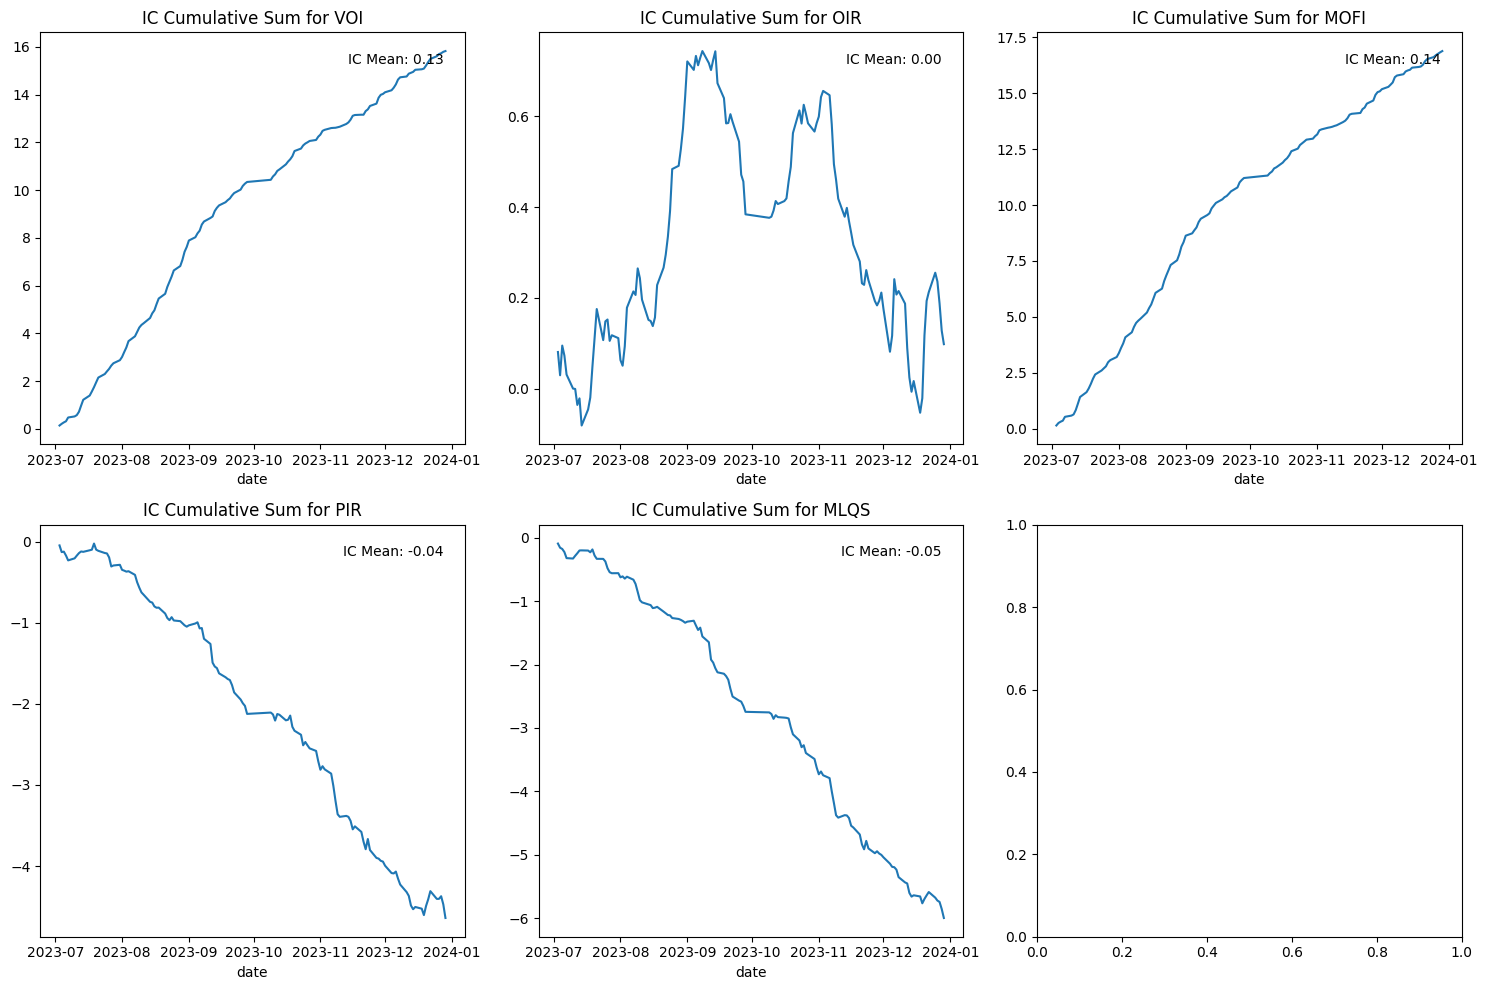

In [140]:
import matplotlib.pyplot as plt

def calc_IC(s, factor):
    return s[[factor, 'label']].dropna().corr().values[0][1]

factors_list = ['VOI', 'OIR', 'MOFI', 'PIR', 'MLQS']

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, factor in enumerate(factors_list):
    ic_ = factors.groupby('date').apply(calc_IC, factor=factor)
    ic_mean = ic_.mean()
    ic_.cumsum().plot(ax=axs[i//3, i%3])
    axs[i//3, i%3].set_title(f'IC Cumulative Sum for {factor}')
    axs[i//3, i%3].text(0.95, 0.95, f'IC Mean: {ic_mean:.2f}', 
                         horizontalalignment='right', 
                         verticalalignment='top', 
                         transform=axs[i//3, i%3].transAxes)

plt.tight_layout()
plt.savefig('my_figure_2.png')
plt.show()

In [128]:
def compute_drawdown_duration_peaks(dd: pd.Series):
    '''
    dd: drawdown
    '''
    iloc = np.unique(np.r_[(dd==0).values.nonzero()[0], len(dd) - 1])
    iloc = pd.Series(iloc, index=dd.index[iloc])
    df = iloc.to_frame('iloc').assign(prev=iloc.shift())
    df = df[df['iloc'] > df['prev'] + 1].astype(int)
    #若没有交易，则返回nan序列
    if not len(df):
        return (dd.replace(0 ,np.nan), ) * 2
    df['duration'] = df['iloc'].map(dd.index.__getitem__) - df['prev'].map(dd.index.__getitem__)
    df['peak_dd'] = df.apply(lambda row: dd.iloc[row['prev']:row['iloc']+1].max(), axis=1)
    df = df.reindex(dd.index)
    return df['duration'], df['peak_dd']

In [ ]:
import time
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import (RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
        
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state = 0),
}

model_grid_params = {
    'RandomForestClassifier': {'max_features':[None],'n_estimators':[5,7,10],'max_depth':[5,7,9,10],\
                               'min_samples_split':[2],'criterion':['entropy'],\
                               'min_samples_leaf':[3]},'max_features':[0.5, 0.7, 0.9, 1]
}
targets_col = ['VOI', 'OIR', 'MOFI', 'PIR', 'MLQS',
       'mid_price','VOI_lag1', 'VOI_lag2', 'VOI_lag3',
       'VOI_lag4', 'VOI_lag5', 'OIR_lag1', 'OIR_lag2', 'OIR_lag3', 'OIR_lag4',
       'OIR_lag5', 'OIR_lag6', 'OIR_lag7', 'OIR_lag8', 'OIR_lag9', 'OIR_lag10',
       'PIR_lag1', 'PIR_lag2', 'PIR_lag3', 'PIR_lag4', 'PIR_lag5', 'PIR_lag6',
       'PIR_lag7', 'PIR_lag8', 'PIR_lag9', 'PIR_lag10', 'MLQS_lag1',
       'MLQS_lag2', 'MLQS_lag3', 'MLQS_lag4', 'MLQS_lag5', 'MLQS_lag6',
       'MLQS_lag7', 'MLQS_lag8', 'MLQS_lag9', 'MLQS_lag10', 'MOFI_lag2',
       'MOFI_lag3', 'MOFI_lag4']

In [ ]:
class Model:
    def __init__(self, models, model_grid_params, data, targets_col):
        self.models = models
        self.model_grid = model_grid_params
        self.data = data
        self.keys = models.keys()
        self.grid = {key: [] for key in self.keys}
        self.predict_values = {key: [] for key in self.keys}
        self.true_values = {key: [] for key in self.keys}
        self.acc = {key: [] for key in self.keys}
        self.fscore = {key: [] for key in self.keys}
        self.true_values = {key: [] for key in self.keys}
        self.targets_col = targets_col
        
    def train_test_split(self):
        unique_dates = self.data['date'].unique()
        unique_dates.sort()
        first_93_dates = unique_dates[:93]
        self.X_train = self.data[self.data['date'].isin(first_93_dates)][self.targets_col]
        self.y_train = self.data[self.data['date'].isin(first_93_dates)]['label']
        last_31_dates = unique_dates[-31:]
        self.X_test = self.data[self.data['date'].isin(last_31_dates)][self.targets_col]
        self.y_test = self.data[self.data['date'].isin(last_31_dates)]['label']
        
    def Grid_fit(self, cv=3, scoring='accuracy'):
        tscv = TimeSeriesSplit(n_splits=cv)
        for key in self.keys:
            print("Running GridSearchCV for %s." %(key))
            model = self.models[key]
            model_grid = self.model_grid[key]
            Grid = GridSearchCV(model, model_grid, cv=tscv, scoring=scoring)
            Grid.fit(self.X_train, self.y_train)
            self.grid[key] = Grid
            print(Grid.best_params_)
            print('CV Best Score = %s' % (Grid.best_score_))
            self.acc[key].append(Grid.best_score_)  
            
    def model_fit(self):
        
        for key in self.keys:
            print("Running training & testing for %s." %(key))
            model = self.models[key]
            model.set_params(**self.grid[key].best_params_)
            model.fit(self.X_train, self.y_train)
            predictions = model.predict(self.X_test)
            self.predict_values[key].append(predictions.tolist())
            self.true_values[key].append(self.y_test.tolist())
            acc = metrics.accuracy_score(self.y_test,predictions)
            f_score = metrics.f1_score(self.y_test,predictions, average='macro')  # 修改这里
            print('Accuracy = %s'%(acc))
            self.acc[key].append(acc)
            self.fscore[key].append(f_score)
        
            feature_imp = dict(zip([i for i in range(0,44,1)],model.feature_importances_))
            Top_five = sorted(feature_imp.items(),key = lambda x : x[1] , reverse=True)[0:5]
            print('Top five importance features = %s'%(Top_five))
            pass
    def model_save(self):
        for key in self.keys:
            model = self.models[key]
            model.set_params(**self.grid[key].best_params_)
            dump(model, '/kaggle/working/' + key + '.joblib')

In [ ]:
model_ = Model(models, model_grid_params, factors, targets_col)
model_.train_test_split()
model_.Grid_fit()

In [ ]:
model_.model_fit()

In [ ]:
result = model_.predict_values
import pickle
with open('/kaggle/working/result.pickle', 'wb') as file:
    pickle.dump(result, file)
model_.model_save()

In [72]:
def getTradingAnalyse(netValue):

    netValue.index = pd.to_datetime(netValue.index)
    tmp = pd.Series(data=np.NaN, index=pd.date_range(netValue.index[0], netValue.index[-1], freq='D'))
    tmp.loc[netValue.index] = netValue
    tmp = tmp.dropna()
    netValue = tmp
    #填充非交易日净值数据
    netValue = netValue.fillna(method='ffill')
    dailyReturn = netValue - netValue.shift(1).fillna(1)
    days = len(dailyReturn)
    years = (dailyReturn.index[-1]-dailyReturn.index[0]).days/365
    dailyReturn = dailyReturn.iloc[1:]
    mean = np.mean(dailyReturn)
    std = np.std(dailyReturn)*((days-1)/(days-2))**0.5
    annualStd = np.round(250 ** 0.5*std, 6)
    sharpe = np.round(250 ** 0.5 * mean / std,6)
    win = sum(dailyReturn > 0) / sum(dailyReturn != 0)
    winLoss = dailyReturn[dailyReturn > 0].mean() / np.abs(dailyReturn[dailyReturn < 0].mean())
    drawdown = 1 - (netValue / netValue.cummax()) #netValue.cummax() / netValue - 1 
    # print(drawdown[drawdown <= 0])
    maxDd = np.round(max(drawdown),6)
    absReturn = np.round(netValue.iloc[-1] - 1,6)
    annualReturn = np.round(absReturn/years,6)
    calmar = np.round(annualReturn / maxDd,6)

    performance = pd.DataFrame([annualStd, sharpe, calmar, absReturn, annualReturn, maxDd] +
                                [win,winLoss, ],
                                index=['stddev(annual)', 'sharpe',
                                        'calmar', 'absReturn', 'annualReturn',
                                        'maxDrawdown', 'win','winLoss', ])
    return performance  

In [15]:
from tqdm import tqdm_notebook
def calc_daily_ret(data, inivalue):
    signal = 0
    pnl = 0
    total_size = 0  
    trade_log = []
    daily_pnl = {}
    current_date = None
    
    for i in tqdm_notebook(range(len(data))):
        row = data.iloc[i]
        if current_date is None:
            current_date = row['date']
        elif current_date != row['date']:
            open_trades = 0
            for trade in trade_log:
                if trade['date'] == current_date:
                    if trade['side'] == 'buy':
                        open_trades += trade['size']
                    elif trade['side'] == 'sell':
                        open_trades -= trade['size']
            if open_trades > 0:
                close_price = data.iloc[i-1]['ask_price1']
                fee = close_price * open_trades * 100 * 0.0006
                execute_price = close_price + fee / (open_trades * 100)
                pnl += open_trades * close_price * 100 - fee
                trade_log.append({
                    'date': data.iloc[i-1]['date'],
                    'time': data.iloc[i-1]['clock_int'],
                    'price': execute_price,
                    'size': open_trades,
                    'side': 'sell',
                    'current': data.iloc[i-1]['current'],
                    'bid_price1': data.iloc[i-1]['bid_price1'],
                    'ask_price1': data.iloc[i-1]['ask_price1']
                })
            elif open_trades < 0:
                open_trades = (-1) * open_trades
                close_price = data.iloc[i-1]['bid_price1']
                fee = close_price * open_trades * 100 * 0.0001
                execute_price = close_price + fee / (open_trades * 100)
                pnl -= open_trades * close_price * 100 + fee
                trade_log.append({
                    'date': data.iloc[i-1]['date'],
                    'time': data.iloc[i-1]['clock_int'],
                    'price': execute_price,
                    'size': open_trades,
                    'side': 'buy',
                    'current': data.iloc[i-1]['current'],
                    'bid_price1': data.iloc[i-1]['bid_price1'],
                    'ask_price1': data.iloc[i-1]['ask_price1']
                })
            daily_pnl[current_date] = pnl / inivalue

            pnl = 0
            current_date = row['date']
            total_size = 0
            signal = 0

        
        if i == len(data) - 1:
            row = data.iloc[i]
            current_date = row['date']
            open_trades = 0
            for trade in trade_log:
                if trade['date'] == current_date:
                    if trade['side'] == 'buy':
                        open_trades += trade['size']
                    elif trade['side'] == 'sell':
                        open_trades -= trade['size']
            if open_trades > 0:
                close_price = data.iloc[i]['ask_price1']
                fee = close_price * open_trades * 100 * 0.0006
                execute_price = close_price + fee / (open_trades * 100)
                pnl += open_trades * close_price * 100 - fee
                trade_log.append({
                    'date': data.iloc[i]['date'],
                    'time': data.iloc[i]['clock_int'],
                    'price': execute_price,
                    'size': open_trades,
                    'side': 'sell',
                    'current': data.iloc[i]['current'],
                    'bid_price1': data.iloc[i]['bid_price1'],
                    'ask_price1': data.iloc[i]['ask_price1']
                })
            elif open_trades < 0:
                open_trades = (-1) * open_trades
                close_price = data.iloc[i]['bid_price1']
                fee = close_price * open_trades * 100 * 0.0001
                execute_price = close_price + fee / (open_trades * 100)
                pnl -= open_trades * close_price * 100 + fee
                trade_log.append({
                    'date': data.iloc[i]['date'],
                    'time': data.iloc[i]['clock_int'],
                    'price': execute_price,
                    'size': open_trades,
                    'side': 'buy',
                    'current': data.iloc[i]['current'],
                    'bid_price1': data.iloc[i]['bid_price1'],
                    'ask_price1': data.iloc[i]['ask_price1']
                })
            daily_pnl[current_date] = pnl / inivalue



            
        if signal == 0:
            if data.iloc[i]['signal'] == 1:
                signal = 1
                size = min(round(inivalue / data.iloc[i]['current'] // 100 * 0.1), data.iloc[i]['volume'] / 100)
                price = data.iloc[i]['bid_price1']
                fee = price * size * 100 * 0.0001
                execute_price = price + fee / (size * 100)
                pnl -= price * size * 100 + fee
                total_size += size  
                trade_log.append({
                    'date': data.iloc[i]['date'],
                    'time': data.iloc[i]['clock_int'],
                    'price': execute_price,
                    'size': size,
                    'side': 'buy',
                    'current': data.iloc[i]['current'],
                    'bid_price1': data.iloc[i]['bid_price1'],
                    'ask_price1': data.iloc[i]['ask_price1']
                })
                
            elif data.iloc[i]['signal'] == -1:
                signal = -1
                size = min(round(inivalue / data.iloc[i]['current'] // 100 * 0.1), data.iloc[i]['volume'] / 100)
                price = data.iloc[i]['ask_price1']
                fee = price * size * 100 * 0.0006
                execute_price = price - fee / (size * 100)
                pnl += price * size * 100 - fee
                total_size += size  
                trade_log.append({
                    'date': data.iloc[i]['date'],
                    'time': data.iloc[i]['clock_int'],
                    'price': execute_price,
                    'size': size,
                    'side': 'sell',
                    'current': data.iloc[i]['current'],
                    'bid_price1': data.iloc[i]['bid_price1'],
                    'ask_price1': data.iloc[i]['ask_price1']
                })
        
        elif signal > 0:
            if data.iloc[i]['signal'] == 1:
                size = min(round(inivalue / data.iloc[i]['current'] // 100 * 0.1), data.iloc[i]['volume'] / 100)
                price = data.iloc[i]['bid_price1']
                fee = price * size * 100 * 0.0001
                execute_price = price + fee / (size * 100)
                pnl -= price * size * 100 + fee
                total_size += size  
                trade_log.append({
                    'date': data.iloc[i]['date'],
                    'time': data.iloc[i]['clock_int'],
                    'price': execute_price,
                    'size': size,
                    'side': 'buy',
                    'current': data.iloc[i]['current'],
                    'bid_price1': data.iloc[i]['bid_price1'],
                    'ask_price1': data.iloc[i]['ask_price1']
                })
                
            elif data.iloc[i]['signal'] == -1:
                price = data.iloc[i]['ask_price1']
                fee = price * total_size * 100 * 0.0006
                execute_price = price - fee / (total_size * 100)
                pnl += total_size * price * 100 - fee  
                trade_log.append({
                    'date': data.iloc[i]['date'],
                    'time': data.iloc[i]['clock_int'],
                    'price': execute_price,
                    'size': total_size,
                    'side': 'sell',
                    'current': data.iloc[i]['current'],
                    'bid_price1': data.iloc[i]['bid_price1'],
                    'ask_price1': data.iloc[i]['ask_price1']
                })
                signal = 0
                size = 0
                total_size = 0  
        
        elif signal < 0:
            if data.iloc[i]['signal'] == -1:
                size = min(round(inivalue / data.iloc[i]['current'] // 100 * 0.1), data.iloc[i]['volume'] / 100)
                price = data.iloc[i]['ask_price1']
                fee = price * size * 100 * 0.0006
                execute_price = price - fee / (size * 100)
                pnl += price * size * 100 - fee
                total_size += size  
                trade_log.append({
                    'date': data.iloc[i]['date'],
                    'time': data.iloc[i]['clock_int'],
                    'price': execute_price,
                    'size': size,
                    'side': 'sell',
                    'current': data.iloc[i]['current'],
                    'bid_price1': data.iloc[i]['bid_price1'],
                    'ask_price1': data.iloc[i]['ask_price1']
                })
                
            elif data.iloc[i]['signal'] == 1:
                price = data.iloc[i]['bid_price1']
                fee = price * total_size * 100 * 0.0001
                execute_price = price + fee / (size * 100)
                pnl -= total_size * price * 100 + fee  
                trade_log.append({
                    'date': data.iloc[i]['date'],
                    'time': data.iloc[i]['clock_int'],
                    'price': execute_price,
                    'size': total_size,
                    'side': 'buy',
                    'current': data.iloc[i]['current'],
                    'bid_price1': data.iloc[i]['bid_price1'],
                    'ask_price1': data.iloc[i]['ask_price1']
                })
                signal = 0
                size = 0
                total_size = 0

    return daily_pnl, pd.DataFrame(trade_log)


In [16]:
import pickle
with open('/Users/lihaohan/因子选股/人工智能选股/intern/燧石/BackTest/result.pickle', 'rb') as file:
    pred = pickle.load(file)
pred = pred['RandomForestClassifier'][0]

In [17]:
df['shifted_current'] = df.groupby('date')['current'].shift(10)
df['label_ret'] = (df['current'] / df['shifted_current'] - 1) * 100
df.drop(columns='shifted_current', inplace=True)
def add_lags(group, columns_lags):
    for column, lags in columns_lags.items():
        for lag in lags:
            group[f'{column}_lag{lag}'] = group[column].shift(lag)
    return group

columns_lags = {
    'VOI': range(1, 6),  
    'OIR': range(1, 11), 
    'PIR': range(1, 11), 
    'MLQS': range(1, 11), 
    'MOFI': range(2, 5)  
}

df = df.groupby('date').apply(add_lags, columns_lags=columns_lags)
df = df.reset_index(drop=True)
df.dropna(inplace=True)

/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/2033695158.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('date').apply(add_lags, columns_lags=columns_lags)


In [18]:
dates = df['date'].unique()
last_31_dates = dates[-31:]
pred_data = df[df['date'].isin(last_31_dates)]

In [59]:
pred_data = df[df['date'].isin(last_31_dates)]

In [60]:
len(pred_data)

146439

In [61]:
pred_data['signal'] = pred
pred_data = pred_data[['clock', 'clock_int', 'date','current', 'volume', 'bid_price1', 'ask_price1', 'signal']]
pred_data.head()

/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/2793414185.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_data['signal'] = pred


,clock,clock_int,date,current,volume,bid_price1,ask_price1,signal
426853,2023-11-17 09:30:30.000,93030000,2023-11-17,33.51,29900.0,33.51,33.58,-1
426854,2023-11-17 09:30:33.000,93033000,2023-11-17,33.50,48000.0,33.50,33.51,-1
426855,2023-11-17 09:30:36.000,93036000,2023-11-17,33.51,24497.0,33.49,33.51,0
426856,2023-11-17 09:30:39.000,93039000,2023-11-17,33.50,23900.0,33.48,33.49,0
426857,2023-11-17 09:30:42.000,93042000,2023-11-17,33.50,49500.0,33.50,33.51,-1


In [62]:
data_ = pred_data[pred_data['date'] != date(2023,11,28)]
data_.head()

,clock,clock_int,date,current,volume,bid_price1,ask_price1,signal
426853,2023-11-17 09:30:30.000,93030000,2023-11-17,33.51,29900.0,33.51,33.58,-1
426854,2023-11-17 09:30:33.000,93033000,2023-11-17,33.50,48000.0,33.50,33.51,-1
426855,2023-11-17 09:30:36.000,93036000,2023-11-17,33.51,24497.0,33.49,33.51,0
426856,2023-11-17 09:30:39.000,93039000,2023-11-17,33.50,23900.0,33.48,33.49,0
426857,2023-11-17 09:30:42.000,93042000,2023-11-17,33.50,49500.0,33.50,33.51,-1


In [63]:
len(data_)

141709

<Axes: >

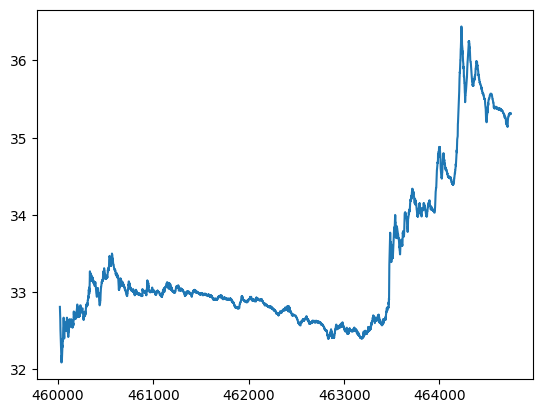

In [52]:
data_['current'].plot()

<Axes: >

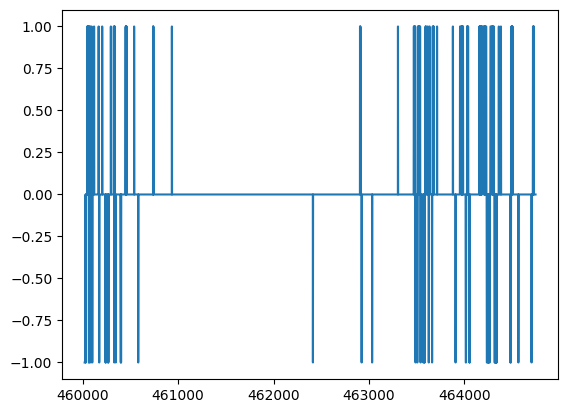

In [53]:
data_['signal'].plot()

In [202]:
factors.head()

,date,current,VOI,OIR,spread,MOFI,PIR,MLQS,mid_price,label_ret,...,MLQS_lag5,MLQS_lag6,MLQS_lag7,MLQS_lag8,MLQS_lag9,MLQS_lag10,MOFI_lag2,MOFI_lag3,MOFI_lag4,label
0,2023-07-03,30.000000,0.000000e+00,-0.702982,0.120001,8.749878e+05,-0.002917,-0.000464,29.940,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2023-07-03,29.990000,-8.051119e+05,-0.663036,0.090000,-7.193391e+05,-0.002784,-0.000542,29.945,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2023-07-03,29.799999,-8.205974e+06,-0.801394,0.060001,-7.999634e+06,-0.003159,-0.000728,29.830,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.749948e+06,NaN,NaN,0
3,2023-07-03,29.799999,-5.059614e+04,0.896657,0.119999,-2.106519e+05,-0.003666,-0.000658,29.740,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-5.395101e+05,875001.668988,NaN,0
4,2023-07-03,30.049999,2.376686e+06,0.060329,0.110001,6.267864e+05,-0.003339,-0.000579,29.965,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-4.363512e+06,-588547.925063,954533.482499,0


In [64]:
daily_pnl, trade_log = calc_daily_ret(data_, 5000000)

/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/387013296.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(len(data))):


  0%|          | 0/141709 [00:00<?, ?it/s]

/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/387013296.py:151: RuntimeWarning: invalid value encountered in scalar divide
  execute_price = price + fee / (size * 100)
/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/387013296.py:113: RuntimeWarning: invalid value encountered in scalar divide
  execute_price = price + fee / (size * 100)
/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/387013296.py:189: RuntimeWarning: invalid value encountered in scalar divide
  execute_price = price - fee / (size * 100)


In [24]:
trade_log

,date,time,price,size,side,current,bid_price1,ask_price1
0,2023-11-17,93030000,33.559852,149.0,sell,33.51,33.51,33.58
1,2023-11-17,93033000,33.489894,149.0,sell,33.50,33.50,33.51
2,2023-11-17,93042000,33.489894,149.0,sell,33.50,33.50,33.51
3,2023-11-17,93200000,33.570068,447.0,buy,33.58,33.56,33.60
4,2023-11-17,93318000,33.653365,72.0,buy,33.65,33.65,33.66
...,...,...,...,...,...,...,...,...
2144,2023-12-29,132426000,27.932793,179.0,buy,27.93,27.93,27.94
2145,2023-12-29,132429000,27.912791,179.0,buy,27.92,27.91,27.92
2146,2023-12-29,133026000,27.723356,419.0,sell,27.73,27.73,27.74
2147,2023-12-29,134429000,27.862786,179.0,buy,27.88,27.86,27.88


In [70]:
trade_freq = pd.DataFrame(trade_log.groupby(['date'])['size'].size().reset_index()).rename(columns={'date':'Date'})
trade_freq['Date'] = pd.to_datetime(trade_freq['Date'])

In [39]:
from datetime import date
test_data = trade_log[trade_log['date'] == date(2023,11,28)]
test_data

,date,time,price,size,side,current,bid_price1,ask_price1
379,2023-11-28,93031000,32.790314,152.0,sell,32.81,32.80,32.81
380,2023-11-28,93034000,32.750338,152.0,sell,32.77,32.76,32.77
381,2023-11-28,93037000,32.720356,153.0,sell,32.74,32.72,32.74
382,2023-11-28,93040000,32.660392,153.0,sell,32.68,32.67,32.68
383,2023-11-28,93043000,32.600428,153.0,sell,32.65,32.59,32.62
...,...,...,...,...,...,...,...,...
653,2023-11-28,145543000,35.273527,142.0,buy,35.27,35.27,35.28
654,2023-11-28,145552000,35.293529,142.0,buy,35.29,35.29,35.30
655,2023-11-28,145555000,35.303530,142.0,buy,35.30,35.30,35.31
656,2023-11-28,145601000,35.303530,142.0,buy,35.30,35.30,35.31


In [40]:
test_data['size'] = test_data.apply(lambda row: row['size'] if row['side'] == 'buy' else -row['size'], axis=1)
test_data.head()

/var/folders/t7/w_83l6_15xs529n5_m3v63x00000gn/T/ipykernel_66983/685346260.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['size'] = test_data.apply(lambda row: row['size'] if row['side'] == 'buy' else -row['size'], axis=1)


,date,time,price,size,side,current,bid_price1,ask_price1
379,2023-11-28,93031000,32.790314,-152.0,sell,32.81,32.80,32.81
380,2023-11-28,93034000,32.750338,-152.0,sell,32.77,32.76,32.77
381,2023-11-28,93037000,32.720356,-153.0,sell,32.74,32.72,32.74
382,2023-11-28,93040000,32.660392,-153.0,sell,32.68,32.67,32.68
383,2023-11-28,93043000,32.600428,-153.0,sell,32.65,32.59,32.62


In [49]:
test_data.tail()

,date,time,price,size,side,current,bid_price1,ask_price1,cumulative_size
653,2023-11-28,145543000,35.273527,142.0,buy,35.27,35.27,35.28,426.0
654,2023-11-28,145552000,35.293529,142.0,buy,35.29,35.29,35.30,568.0
655,2023-11-28,145555000,35.303530,142.0,buy,35.30,35.30,35.31,710.0
656,2023-11-28,145601000,35.303530,142.0,buy,35.30,35.30,35.31,852.0
657,2023-11-28,145658000,35.331186,-852.0,sell,35.31,35.29,35.31,0.0


In [50]:
max(test_data['cumulative_size']) * 100

695200.0

In [47]:
5000000 / 30

166666.66666666666

<Axes: >

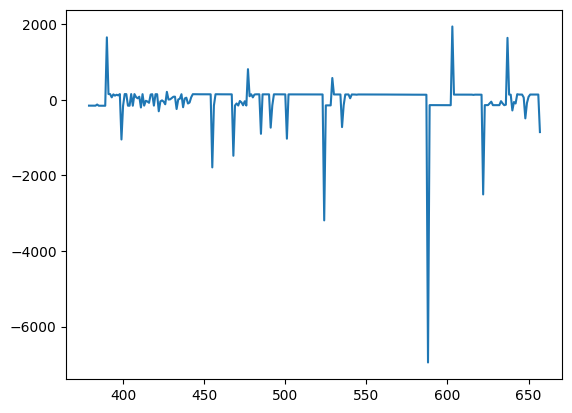

In [44]:
test_data['size'].plot()

In [206]:
test_data = test_data[['date', 'clock_int']]
trade_log = trade_log[['date', 'time', 'size', 'side']]

In [1]:
trade_log.head()

NameError: name 'trade_log' is not defined

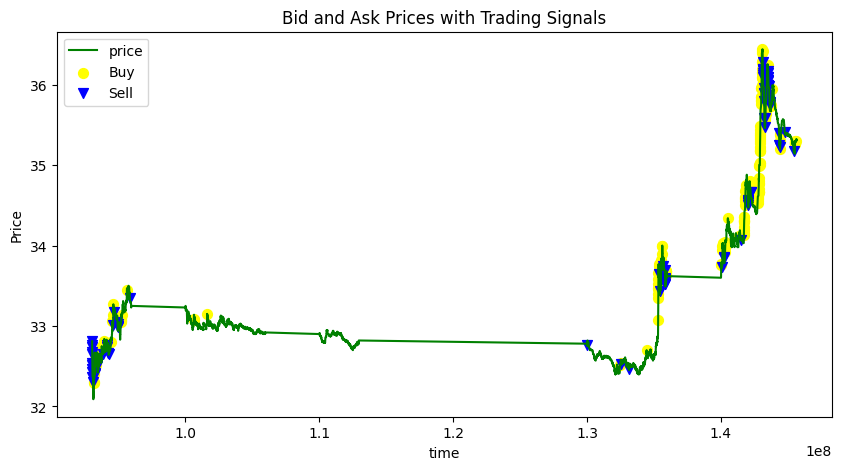

In [175]:
signal_positive = test_data[test_data['signal'] == 1]
signal_negative = test_data[test_data['signal'] == -1]

plt.figure(figsize=(10, 5))

plt.plot(test_data.clock_int, test_data['current'], label='price', color='green')

plt.scatter(signal_positive.clock_int, signal_positive['current'], color='yellow', marker='o', s=50, label='Buy')
plt.scatter(signal_negative.clock_int, signal_negative['current'], color='blue', marker='v', s=50, label='Sell')

plt.title('Bid and Ask Prices with Trading Signals')
plt.xlabel('time')
plt.ylabel('Price')
plt.legend()
plt.savefig('my_figure_4.png')
plt.show()


In [65]:
pnl = pd.DataFrame(list(daily_pnl.items()), columns=['Date', 'Pnl'])
pnl

,Date,Pnl
0,2023-11-17,-0.010556
1,2023-11-20,0.003537
2,2023-11-21,-0.002221
3,2023-11-22,0.023708
4,2023-11-23,0.008196
5,2023-11-24,0.007666
6,2023-11-27,0.010021
7,2023-11-29,0.014360
8,2023-11-30,-0.005329
9,2023-12-01,0.000960


<Figure size 1000x600 with 0 Axes>

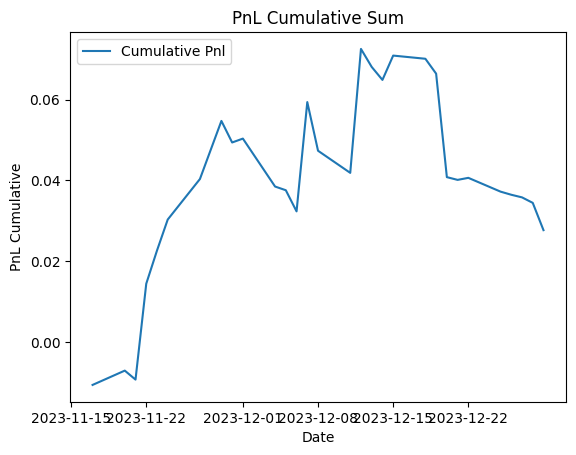

In [66]:
import matplotlib.pyplot as plt

# 计算Value列的累积和
pnl['Cumulative Pnl'] = pnl['Pnl'].cumsum()

# 创建图形
plt.figure(figsize=(10, 6))

# 绘制累积和
pnl.plot(x='Date', y='Cumulative Pnl')

# 设置标题和标签
plt.title('PnL Cumulative Sum')
plt.xlabel('Date')
plt.ylabel('PnL Cumulative')

# 显示图形
plt.show()

In [67]:
pnl.reset_index(inplace=True)

In [68]:
pnl['Date'] = pd.to_datetime(pnl['Date'])

In [71]:
pnl = pd.merge(pnl, trade_freq, on='Date')
pnl

,index,Date,Pnl,Cumulative Pnl,size
0,0,2023-11-17,-0.010556,-0.010556,23
1,1,2023-11-20,0.003537,-0.007019,17
2,2,2023-11-21,-0.002221,-0.009240,12
3,3,2023-11-22,0.023708,0.014467,99
4,4,2023-11-23,0.008196,0.022664,102
5,5,2023-11-24,0.007666,0.030330,65
6,6,2023-11-27,0.010021,0.040351,61
7,7,2023-11-29,0.014360,0.054712,118
8,8,2023-11-30,-0.005329,0.049383,46
9,9,2023-12-01,0.000960,0.050344,94


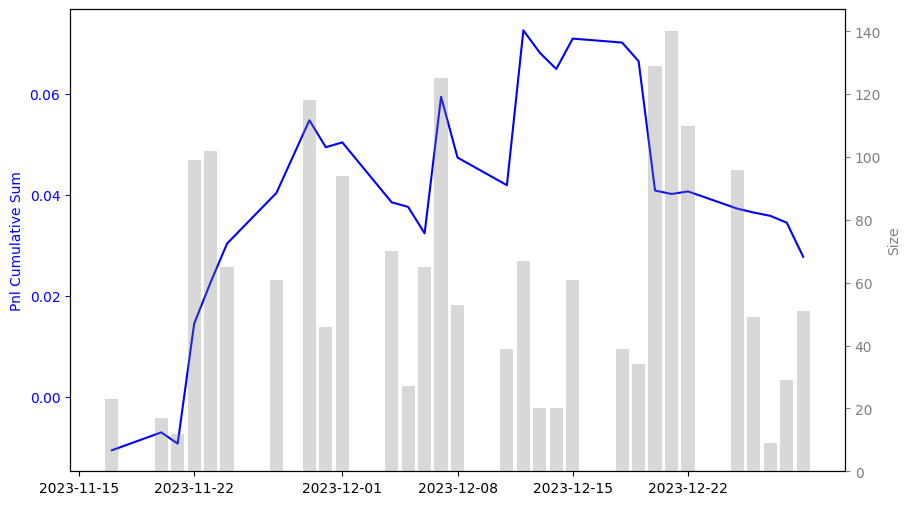

In [72]:
# 计算Pnl的累积和
pnl['Pnl_cumsum'] = pnl['Pnl'].cumsum()

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(pnl['Date'], pnl['Pnl_cumsum'], color='blue')
ax1.set_ylabel('Pnl Cumulative Sum', color='blue')
ax1.tick_params('y', colors='blue')

ax2 = ax1.twinx()

ax2.bar(pnl['Date'], pnl['size'], color='gray', alpha=0.3)
ax2.set_ylabel('Size', color='gray')
ax2.tick_params('y', colors='gray')
plt.savefig('my_figure_5.png')
plt.show()

In [73]:
import pandas as pd
import numpy as np

def getTradingAnalyse(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    dailyReturn = data['Pnl']
    days = len(dailyReturn)
    years = (dailyReturn.index[-1] - dailyReturn.index[0]).days / 365
    
    mean = dailyReturn.mean()
    std = dailyReturn.std()

    annualStd = np.round(np.sqrt(250) * std, 6)
    sharpe = np.round(np.sqrt(250) * mean / std, 6)

    win_ratio = sum(dailyReturn > 0) / sum(dailyReturn != 0)

    win_loss_ratio = dailyReturn[dailyReturn > 0].mean() / np.abs(dailyReturn[dailyReturn < 0].mean())

    cumulative_net_value = (1 + dailyReturn).cumprod()

    drawdown = 1 - (cumulative_net_value / cumulative_net_value.cummax())

    max_dd = np.round(drawdown.max(), 6)

    abs_return = np.round(cumulative_net_value.iloc[-1] - 1, 6)

    annual_return = np.round((1 + abs_return) ** (1 / years) - 1, 6)

    calmar = np.round(annual_return / max_dd, 6)
    performance = pd.DataFrame({
        'Metric': ['Annualized Std Dev', 'Sharpe Ratio', 'Calmar Ratio', 'Total Return', 
                   'Annualized Return', 'Max Drawdown', 'Win Ratio', 'Win/Loss Ratio'],
        'Value': [annualStd, sharpe, calmar, abs_return, annual_return, max_dd, win_ratio, win_loss_ratio]
    }).set_index('Metric')

    return performance

In [74]:
getTradingAnalyse(pnl)

,Value
Metric,
Annualized Std Dev,0.184184
Sharpe Ratio,1.253585
Calmar Ratio,5.671470
Total Return,0.026075
Annualized Return,0.250696
Max Drawdown,0.044203
Win Ratio,0.366667
Win/Loss Ratio,2.183382
